# Deep Learning Applications: Laboratory #1

This laboratory works with CNNs on MNIST and CIFAR-10 dataset. I set up a (mostly handmade) pipeline to train and evaluate models, and experimented logging using [Weights and Biases](https://wandb.ai/site) (WandB).

All the code is available in my [Github repo](https://github.com/ciodar/deep-labs/tree/main/lab1)

## Exercise 1: Warming Up
In this series of exercises I duplicated some of the results of the ResNet paper on CIFAR-10 dataset

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

Before doing so, I will detail the training pipeline I defined, which is used in all the exercises by training a simple MLP on MNIST dataset.

### Training pipeline

In [1]:
# Start with some standard imports.
from os import chdir
from random import randrange
import matplotlib.pyplot as plt
import numpy as np
import wandb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from pathlib import Path
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision.transforms import InterpolationMode
import torchvision.transforms.functional as TF
from torchvision.utils import draw_bounding_boxes

from data_loader import SubsetDataset
from trainer import Trainer,plot_curves
from models.resnet import ResNetForClassification,ResNet


# some utility functions
# sets current directory a the notebook's parent
def make_paths_relative_to_root():
    """Always use the same, absolute (relative to root) paths
    which makes moving the notebooks around easier.
    """
    top_level = Path(__file__).parent
    chdir(top_level)

def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        if isinstance(img, torch.Tensor):
            img = img.detach().cpu()
        if img.shape[0] == 1:
            img = img.repeat(3,1,1)
        img = TF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#Global setting
BATCH_SIZE = 128
DEVICE = 'cuda:0'

#### Data preparation
I define a custom class `SubsetDataset`, which wraps a `Subset` into a `Dataset` object. This will be useful when we'll want to use a different transformation from training and validation on CIFAR-10.

For MNIST dataset I used the following approach
- Data is normalized using the mean and standard deviation of the dataset and then resized to 32x32, to mantain the same size of CIFAR-10. This resize was also used in the original LeNet paper for convolutional networks, as it helps to enlarge the receptive field of convolutional layers.
- 10% of training data is held out and used for validation.

In [2]:
# Load MNIST train dataset
dataset = datasets.MNIST(root='/data',train=True,download=True)
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # antialias required to not throw a warning
    transforms.Resize(32,antialias=False)
])
# Split train into train and validation. We use 10% of the training data as validation
val_size = int(0.1*len(dataset))
I = np.random.permutation(len(dataset))

mnist_train = SubsetDataset(Subset(dataset, I[val_size:]),transform)
mnist_val = SubsetDataset(Subset(dataset, I[:val_size]),transform)

train_data_loader = DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True)
valid_data_loader = DataLoader(mnist_val,batch_size=BATCH_SIZE)

Let's verify that the data is loaded correctly by plotting some images.

Images shape: (128, 1, 32, 32)
Labels shape: (128,)


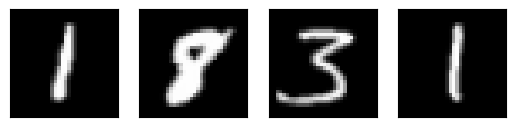

In [3]:
dataiter = iter(train_data_loader)
images,labels = next(dataiter)
print(f'Images shape: {tuple(images.shape)}\nLabels shape: {tuple(labels.shape)}')
# show images
show(images[0:4])

#### WandB logging

I used this laboratory also to experiment with WandB, which is used to log every experiment.
I create a new project, [lab-1](https://wandb.ai/dla-darcio/lab-1) and defined the logic to
- Log train and validation loss and accuracy during the model training
- Log model gradients during training using WandB utility `wandb.watch`
- Save checkpoints to WandB cloud, and flag the best performing epoch
- Download and resume a checkpoint and test its performance

In [8]:
wandb.login()
wandb_config = {
    "project":"lab-1-resnets",
    "job_type": "model_trainer",
    "dataset_name": "mnist",
    "model_collection_name": "MNIST MLP"
}

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


#### Trainer
I defined a custom [Trainer](trainer.py) class to handle the training and validation loop. It allows to
- Train the model, storing training and validation accuracy and loss for each epoch
- Save model checkpoints at each epoch locally and to WandB cloud, linking them to the corresponding run.
- Test the model on the test set. Note this was done only once all models were trained to avoid gaining information about the test set.

While most parameters are configurable, for simplicity I hardcoded the following parameters:
- Loss will be always categorical cross-entropy
- The only used metric is top-1 accuracy. For this reason, I did not bother to create a custom class to store metric results  or configure different metrics, and demanded the entire logging and averaging to WandB.

#### MLP definition
Here I define a MLP class, which allows to specify the dimension of each layer by passing an array
```python
model_mlp = MLP([768,16,16,10])
```

In [5]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        layers = []
        for (in_dim,out_dim) in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(nn.Linear(in_dim,out_dim))
            layers.append(nn.ReLU())
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        out = x.view(x.shape[0],-1)
        out = self.layers(out)
        return out

#### Training configuration

To allow faster experimentation, all the configuration is defined through dictionaries and then logged into WandB.

For the MNIST MLP
- I trained the network for 30 epochs with a learning rate of $10^{-4}$ using Adam optimizer.
- Batch size is 128

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

#### Training

{'epochs': 30, 'lr': 0.0001, 'batch_size': 128, 'width': 100, 'depth': 2}


Epoch 30: 100%|██████████| 422/422 [00:13<00:00, 31.28it/s, step_acc=0.922, step_loss=0.209, train_acc=0.881, train_loss=0.313, valid_acc=0.87, valid_loss=0.343] 

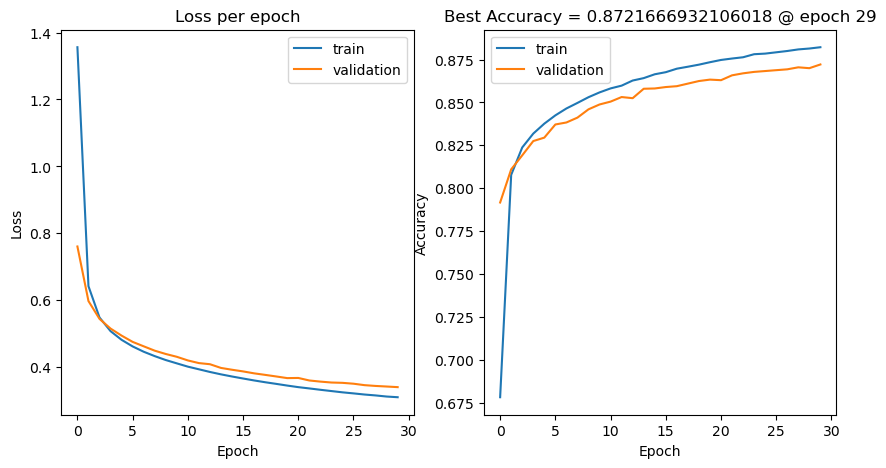

In [6]:
INPUT_SIZE = 32*32

# Training hyperparameters.
trainer_hparams={
    "epochs":30,
    "lr":0.0001,
    "batch_size":128
}

# Architecture hyperparameters.
arch_hparams={
    "width":100,
    "depth":2
}

config = {**trainer_hparams,**arch_hparams}
print(config)

writer = wandb.init(project=wandb_config['project'],config=config,mode='disabled')
# Define a DataLoader for MNIST with train and validation split

# Instantiate model and optimizer.
config = writer.config
model_mlp = MLP([INPUT_SIZE] + [config.width]*config.depth + [10]).to(DEVICE)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=config.lr)
# Begin training
trainer = Trainer(opt,writer,epochs=config.epochs,device=DEVICE, checkpoints=True, **wandb_config)
train_log, val_log = trainer.train(model_mlp,train_data_loader,valid_data_loader)
# plot train and validation logs
plot_curves(train_log,val_log)

### Exercise 1.2: Rinse and Repeat

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Spoiler**: If you plan to do optional exercise 3.3, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

#### CIFAR-10 Data preparation
Here I define my dataset for CIFAR-10. Input images are per-pixel normalized along every channel. Mean and std are computed with the following code

In [2]:
# Load CIFAR train set
cifar_ds = datasets.CIFAR10(root='/data',train=True,download=True)
# Compute mean and std
mean = np.mean(cifar_ds.data, axis=(0,1,2))/255
std = np.std(cifar_ds.data, axis=(0,1,2))/255
print(f"Mean: {mean} - std: {std}")

Files already downloaded and verified
Mean: [0.49139968 0.48215841 0.44653091] - std: [0.24703223 0.24348513 0.26158784]


##### Data augmentation
Data augmentation is performed as in the paper
- The 32x32 is padded with 4 pixel on each side
- A random crop of 32x32 is taken from the padded image or its horizontal flip

Validation is 10% of training dataset. On this set, I only perform per-pixel normalization

In [4]:
# normalize data based on train split
normalize = transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
# Data augmentation and normalization for training
# Just normalization for validation
transform = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        normalize
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]),
}

# Split train into train and validation.
val_size = int(0.1 * len(cifar_ds))
I = np.random.permutation(len(cifar_ds))

cifar_val = SubsetDataset(Subset(cifar_ds, I[:val_size]), transform['val'])
cifar_train = SubsetDataset(Subset(cifar_ds, I[val_size:]), transform['train'])

cifar_train_loader = DataLoader(cifar_train, batch_size=BATCH_SIZE, shuffle=True)
cifar_val_loader = DataLoader(cifar_val, batch_size=BATCH_SIZE)

To make sure that the the images and labels are in the correct format let's display a few samples. We can see that the images are not centered anymore due to the data augmentation procedure.

torch.Size([128, 3, 32, 32]) torch.Size([128])


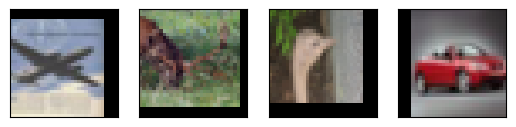

In [5]:
dataiter = iter(cifar_train_loader)
images,labels = next(dataiter)
# unnormalize images
images = images * std[:,None,None] + mean[:,None,None]
print(images.shape, labels.shape)
# show images
show(images[0:4])

#### Model definition
Here I define the convolutional network, which follows the ResNet definition of the paper for CIFAR-10.
The network is composed by an initial $3\times3$ convolutional layer, followed by a stack of $6n$ layers with $3 \times 3$ convolutions on feature maps of sizes {32,16,8}, with $2n$ layers for each feature map size.
The number of filters is doubled every time the size of the feature map is halved, to mantain the same number of operations.


| Output map size | 32 x 32 | 16 x 16 | 8 x 8 |
|-----------------|---------|---------|-------|
| # layers        | 1 + 2n  | 2n      | 2n    |
| # filters       | 16      | 32      | 64    |

##### Residual Block
To allow an easy modification of the model's depth and enabling/disabling residual connections, I created a `ResidualBlock` Module, which allows to add blocks of two convolutional layers to the network.
- The block consists of two convolutional layers, each followed by a Batch Normalization Layer before the ReLU activation.
- Downsampling is obtained with a strided convolution performed by the first convolutional layer.
- The residual connection is obtained by summing the input feature maps before the second nonlinearity. Since summmation is allowed only if the feature maps have the same shape, a projection layer is added to the residual connection when downsampling is performed.

##### Projection
The paper experiments with three types of projection. I provide an implementation of all three
    A) Parameter-free projection, performed by downsampling the input feature map and padding the remaining channels with zeros
    B) Paremeterized projection with an affine trasformation, followed by a Batch Normalization layer.
    C) Add a parameterized projection to all residual connections

##### Global Average Pooling
The ResNet use a Global Average Pooling layer followed by a Fully connected layer, as defined in [[2](https://arxiv.org/pdf/1312.4400.pdf)]. The Global Average Pooling transforms a feature map $H \times W \times C$ into $1 \times 1 \times C$.
If $C = $ num_classes, the resulting tensor could be directly fed into a softmax for prediction, however we employ a single Fully Connected layer, as done in the paper.

##### Initialization


In [10]:
arch_hparams = {
    "layers": [3] * 3,
    "residual": True,
    "batchnorm": True,
    "num_classes": 10,
    "num_channels": 16,
    "residual_type": 'a'
}

model = ResNetForClassification(**arch_hparams).to(DEVICE)
print(model)

ResNetForClassification(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, tr

#### Training
We can now train convolutional models with and without residual connections.
- Used SGD optimizer, since it usually allows better results [[1](https://arxiv.org/pdf/1705.08292.pdf)], but needs to be trained for more epochs than Adam.
- Following the paper, I used a momentum of 0.9 and a weight decay of $10^{-4}$.
- The learning rate is initially set as 0.1 and divided by 10 at epochs 50 and 75, and training ends at epoch 85.

I trained models, with 3, 5 and 9 blocks per layer, leading to 20, 32 and 56 layer architectures, without residual connections (*plain*) or with residual connections (*residual*)
Training logs are available [here](https://wandb.ai/dla-darcio/lab-1-resnets) or by executing in terminal:

```bash
wandb dla-darcio/lab-1-resnets
```

Models were trained by executing the following command in terminal:

```bash
python train.py --num_layers <number of layers per block> --<residual | no-residual> --batchnorm --checkpoints
```

#### Experimental results
A full report on the results is available [here](https://wandb.ai/dla-darcio/lab-1-resnets/reports/Lab-1-Residual-Networks--Vmlldzo0MzQxMTIx).

We can see that deeper networks without residual connections (dashed lines) obtain a lower accuracy than shallower plain networks. The 56-layer newtork starts to exhibit large fluctuations in the accuracy and loss, which may be a linked to a bad optimization process and achieves a -3.4% accuracy compared to the 20-Layer plain network.

In contrast, deeper residual networks (continuous lines) exhibit a better performance than shallower ones, with the 56-Layer architecture achieving a +1.5% accuracy compared to the 20-Layer architecture.

![Accuracy](./assets/plain_res_accuracy.png)

##### We need to go deeper
As stated by the famous [meme](https://knowyourmeme.com/memes/we-need-to-go-deeper), I tried additional, deeper configurations, such as a 101-layer configuration and a 152-layer configuration to verify if deeper residual networks perform worse, and explain why.

In this case we can see that the 56-layer and the 101-layer configuration achieve similar results, with the 101-layer configuration leading to a slightly better accuracy (+0.2%).
The 152-layer configuration, however, leads to a lower accuracy than the 56-layer configuration (-0.5%).


![Accuracy](./assets/deep_res_accuracy.png)

Looking at the loss on the validation set, we see that for 101-layer and 152-layer configuration the loss starts to rise again after a certain number of epochs, which is a sign of overfitting.
We can thus attribute the lower accuracy of the 152-layer configuration to overfitting.


![Loss](./assets/deep_res_loss.png)

##### Test Results
These are the results obtained by the models trained in this section on the test set.
The better model is the Resnet-56, which achieves a 90% accuracy.

| Layers | Residual | Parameters | Accuracy  |
|:------:|:--------:|:----------:|:---------:|
|   20   |   Yes    |    270K    |   0.872   |
|   20   |    No    |    270K    |   0.867   |
|   56   |   Yes    |    835K    | **0.900** |
|   56   |    No    |    835K    |   0.839   |

-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit.

### Exercise 2.2: Fully-convolutionalize a network.
Take one of your trained classifiers and **fully-convolutionalize** it. That is, turn it into a network that can predict classification outputs at *all* pixels in an input image. Can you turn this into a **detector** of handwritten digits? Give it a try.

**Hint 1**: Sometimes the process of fully-convolutionalization is called "network surgery".

**Hint 2**: To test your fully-convolutionalized networks you might want to write some functions to take random MNIST samples and embed them into a larger image (i.e. in a regular grid or at random positions).

#### MNIST Object localization
This experiment uses a fully-convolutionalized ResNet to perform **object localization** on MNIST. This was chosen over **detection** since it and could not use the same training procedure as before, and would require an approach which evaluates both precision and recall and requires more hyperparameters to tune (e.g the threshold for the detection).

#### Fully-convolutional model definition
To make a fully-convolutional model, I only changed two things:
- Associate one feature map to each model class. To achieve this, we can use a 1x1 convolution to pass from 64 to 10 feature maps for MNIST and CIFAR-10
- Removed the last fully-connected layer and replaced it with a $1x1$ global average pooling layer.
- Use a Global Average pooling to calculate the spatial average of each feature map

I created a new class `FullyConvResNet` that inherits from `ResNet`, which defines two methods:
- A standard `forward` method to perform classification
- A localize method to perform classification + localization.

The localization method generates a feature map of dimension $(\text{mapping_size} \times \text{mapping_size})$, which is then transformed into a map of pixel-level probabilities of each class using a 2d softmax function.
Since the network performs downsampling of the input image, this map is smaller than the input image, so that each element in this map is associated to a region of the input image.

In [11]:
class FullyConvResNet(ResNet):
    def __init__(self, num_classes: int = 10, mapping_size = 16, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.project = nn.Conv2d(self.num_channels,num_classes,1)
        self.classifier = nn.AdaptiveAvgPool2d(1)
        # Someway limits
        self.map = nn.AdaptiveAvgPool2d(mapping_size)
        self.s2d = nn.Softmax2d()

    def forward(self, x):
        out = super().forward(x)
        # print(out.shape) # 128,64,4,4
        out = self.project(out)
        # print(out.shape) # 128,10,4,4
        logits = self.classifier(out)
        # print(out.shape) # 128,10,1,1
        return logits.squeeze()

    def localize(self, x):
        out = super().forward(x)
        out = self.project(out)
        # compute classification
        logits = self.classifier(out)
        # compute activation map
        mapping = self.map(out)
        return logits, self.s2d(mapping)

#### Data Loading
To generate the training data, I used the `embed_image` function to embed the MNIST digits into a larger image of size $128 \times 128$.

In [12]:
AUG_SIZE = 128

def embed_image(img):
    channels, width, height = img.shape
    new_img = torch.zeros((channels,AUG_SIZE, AUG_SIZE))
    x_min, y_min = randrange(AUG_SIZE - width), randrange(AUG_SIZE - height)
    x_max, y_max = x_min + width, y_min + height
    new_img[:,x_min:x_max, y_min:y_max] = img
    # print(new_img.shape)
    return new_img

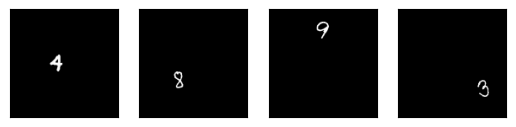

In [20]:
# Load MNIST train dataset
dataset = datasets.MNIST(root='/data',train=True,download=True)
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    embed_image
])
# Split train into train and validation. We use 10% of the training data as validation
val_size = int(0.1*len(dataset))
I = np.random.permutation(len(dataset))

mnist_train = SubsetDataset(Subset(dataset, I[val_size:]),transform)
mnist_val = SubsetDataset(Subset(dataset, I[:val_size]),transform)

train_data_loader = DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True)
valid_data_loader = DataLoader(mnist_val,batch_size=BATCH_SIZE)

dataiter = iter(train_data_loader)
images,labels = next(dataiter)
images, labels = images[0:4], labels[0:4]

show(images)

#### Training
The model is trained as before on the classification task. This time it will be more difficult to classify the digits, since most of the image is empty.

Epoch 30: 100%|██████████| 422/422 [00:17<00:00, 24.11it/s, step_acc=0.922, step_loss=0.209, train_acc=0.881, train_loss=0.313, valid_acc=0.87, valid_loss=0.343]


FullyConvResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): ResidualBlock(
      (project): DownsampleA(
        (downsample): AvgPool2d(kernel_size=1, stride=2, padding=0)
      )
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-

Epoch 5: 100%|██████████| 422/422 [01:29<00:00,  4.47it/s, step_acc=0.977, step_loss=0.0727, train_acc=0.981, train_loss=0.0892, valid_acc=0.974, valid_loss=0.11]

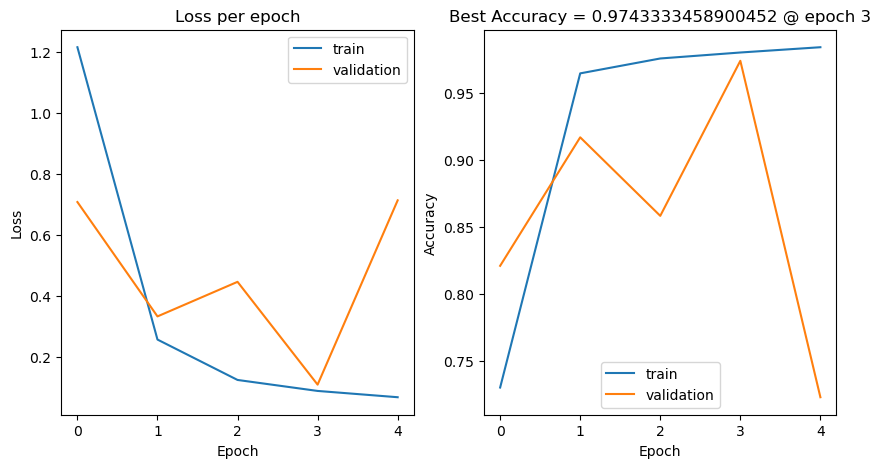

In [14]:
wandb.login()

wandb_config = {
    "project":"lab-1",
    "job_type": "model_trainer",
    "dataset_name": "MNIST-Localization",
    "model_collection_name": "MNIST Fully-conv ResNet"
}

# Training hyperparameters.
optimizer_hparams={
    "lr":1e-3
    #"weight_decay": 1e-4,
}

# Architecture hyperparameters.
arch_hparams={
    "layers":[1]*3,
    "residual": True,
    "num_classes":10,
    "num_channels": 16,
    "residual_type": 'a',
    "grayscale": True
}

config = {
    "optimizer": "Adam",
    "epochs":5,
    **optimizer_hparams,
    **arch_hparams
}

# Initialize WandB logging all hyperparameters
writer = wandb.init(project=wandb_config['project'],config=config,mode='disabled')
config = wandb.config

# Initialize model
model = FullyConvResNet(**arch_hparams).to(DEVICE)
print(model)

# Get optimizer from torch.optim
opt = getattr(torch.optim,config.optimizer)(params=model.parameters(), **optimizer_hparams)

# Begin training
trainer = Trainer(opt,writer,epochs=config.epochs,device=DEVICE,checkpoints=True, **wandb_config)
train_log, val_log = trainer.train(model,train_data_loader,valid_data_loader)
# plot train logs
plot_curves(train_log,val_log)

#### Localization
To perform localization with the trained classifier, we choose the feature map associated to the class with highest probability and use it to generate a heatmap of the same size as the input image.
Since the network performs downsampling during the forward pass, the mapping_size is smaller than the image size. To obtain the bounding box coordinates, we should associate each pixel of this probability map to a set of pixel in the original image.

To simplify this process, I just performed a bicubic interpolation, resizing the heatmap to the original image size. This is not the best solution, but it is a working approximation.

The plotted images should resemble a heatmap of the predicted probability for each pixel.

In [14]:
def get_cam(probs, features):
    resize = torchvision.transforms.Resize(SIZE_UPSAMPLE, interpolation=InterpolationMode.BILINEAR,antialias=False)
    cam = torch.mul(probs[:,:,None,None], features).sum(dim=1, keepdim=True)
    cam = resize(cam)
    cam_img = cam - torch.min(cam)
    cam_img = cam_img / torch.max(cam)
    cam_img = (255 * cam_img).type(torch.uint8)
    return cam, cam_img

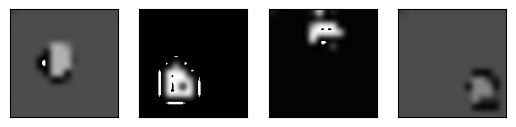

In [38]:
# get logits and activation map
SIZE_UPSAMPLE = (32,32)
# get logits and global average pooling of features
logits, gap = model.localize(images.to(DEVICE))
probs = F.softmax(logits.squeeze(),dim=1)

cam, cam_img = get_cam(probs, gap)

# seg_map = seg_map.unsqueeze(0).unsqueeze(0)

resize = torchvision.transforms.Resize(AUG_SIZE, interpolation=InterpolationMode.BICUBIC, antialias=True)

masks = resize(cam).detach().cpu()
show(masks)
masks = (masks > 0.5).type(torch.uint8)

#### Bounding Box
To transform the heatmap into a bounding box, we set a threshold, to transform the heatmap into a binary mask.
We can then use the `masks_to_boxes` function from `torchvision.ops`. This function returns the coordinates of the bounding box that contains the mask.

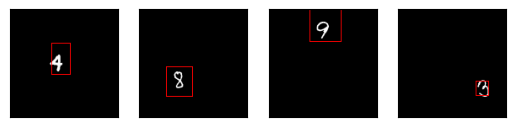

In [39]:
from torchvision.ops import masks_to_boxes
boxes = masks_to_boxes(masks.squeeze())

drawn_boxes = []
for i in range(images.shape[0]):
    img = images[i]
    img = img * 255
    drawn_boxes.append(draw_bounding_boxes(img.type(torch.uint8), boxes[i].unsqueeze(0), colors="red"))
show(drawn_boxes)

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.2 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes.

{'optimizer': 'SGD', 'epochs': 85, 'lr': 0.1, 'wd': 0.0001, 'momentum': 0.9, 'layers': [9, 9, 9], 'residual': True, 'batchnorm': True, 'num_classes': 10, 'num_channels': 16, 'residual_type': 'a'}


Epoch 10: 100%|█████████▉| 351/352 [00:42<00:00,  8.32it/s, step_acc=0.984, step_loss=0.0645, train_acc=0.964, train_loss=0.106, valid_acc=0.976, valid_loss=0.084]

train_accuracy,▁▆▅▅▇▆▅▆▅▄▇▅▅▃▅▇▇▆▅▅█▅▅▅▅▅▅▇▅▅▅▇▇▇▄▇▇▇▄▇
train_loss,█▃▄▃▂▃▂▂▂▃▁▃▃▃▃▂▁▃▄▃▁▄▃▃▃▃▂▂▂▃▃▁▂▂▃▂▂▁▃▂
val_acc,▅▄█▂▇▁▃▆▇▆
val_loss,█▃▃▅▁▃▄▃▅▂
train_accuracy,0.98438
train_loss,0.0645
val_acc,0.976
val_loss,0.07973


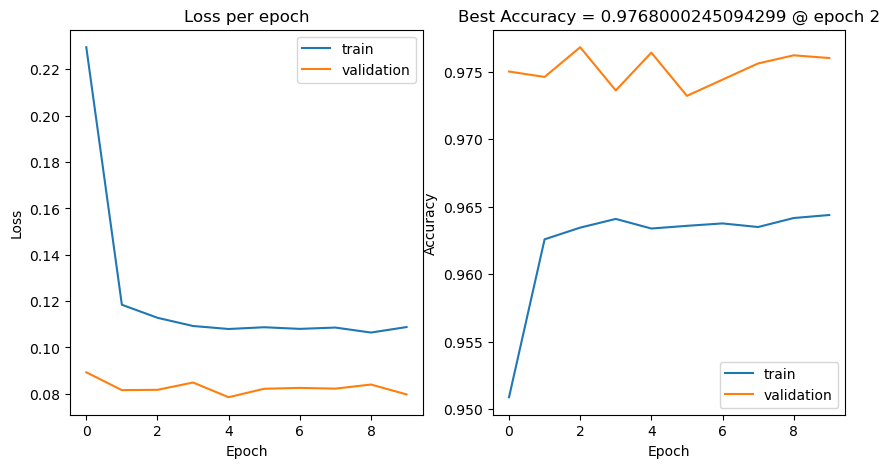

In [48]:
from torch.optim import Adam
from models.resnet import FullyConvResNet

# Best ResNet-56 checkpoint
ckpt_url = 'dla-darcio/lab-1-resnets/cifar10-rhhhe6tv:best'

# Training hyperparameters.
optimizer_hparams={
    "lr":1e-3
    #"weight_decay": 1e-4,
}

# Architecture hyperparameters.
arch_hparams={
    "layers":[9]*3,
    "residual": True,
    "batchnorm": True,
    "num_classes":10,
    "num_channels": 16,
    "residual_type": 'a'
}

config = {
    "optimizer": "Adam",
    "epochs":5,
    **optimizer_hparams,
    **arch_hparams
}

run = wandb.init(mode='online')

model_art = wandb.use_artifact(ckpt_url)
model_path = model_art.get_path("ckpt-best.pth").download()
ckpt = torch.load(model_path, map_location=DEVICE)
# this ignores console params
print(ckpt['config'])

arch_hparams.update((k, config[k]) for k in config.keys() & arch_hparams.keys())
model = FullyConvResNet(**arch_hparams).to(DEVICE)
state_dict = ckpt['state_dict']
model.load_state_dict(state_dict, strict=False)

# Freeze layers
model.conv1.requires_grad_(False)
model.layer1.requires_grad_(False)
model.layer2.requires_grad_(False)
model.layer3.requires_grad_(False)

# Get optimizer from torch.optim
opt = Adam(params=model.parameters(), lr=1e-2)
# Begin training
trainer = Trainer(opt,run,epochs=10,device=DEVICE,checkpoints=True, **wandb_config)
train_log, val_log = trainer.train(model,cifar_train_loader,cifar_val_loader)
# plot train logs
plot_curves(train_log,val_log)

torch.Size([128, 3, 32, 32]) torch.Size([128])


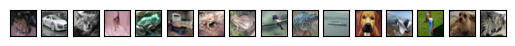

In [49]:
N_IMGS = 16

dataiter = iter(cifar_val_loader)
images,labels = next(dataiter)
images = images * std[:,None,None] + mean[:,None,None]
print(images.shape, labels.shape)
# show images
show(images[:N_IMGS,:,:,:])

(128, 1, 32, 32, 4)
Predicted: 3 | True: 6 | Prob: 0.80289
(1, 32, 32, 4)


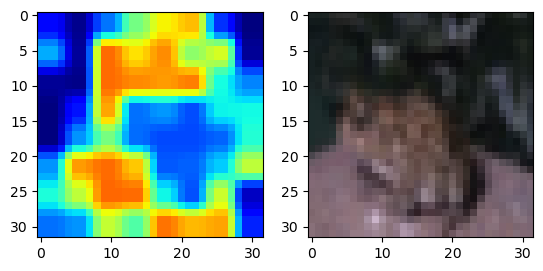

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 1 | True: 1 | Prob: 0.98383
(1, 32, 32, 4)


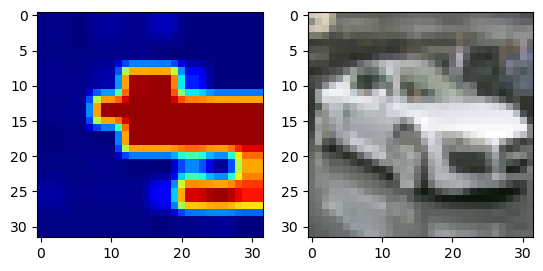

Predicted: 3 | True: 3 | Prob: 0.99908
(1, 32, 32, 4)


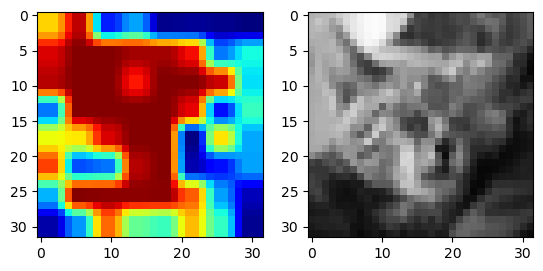

Predicted: 3 | True: 3 | Prob: 0.89215
(1, 32, 32, 4)


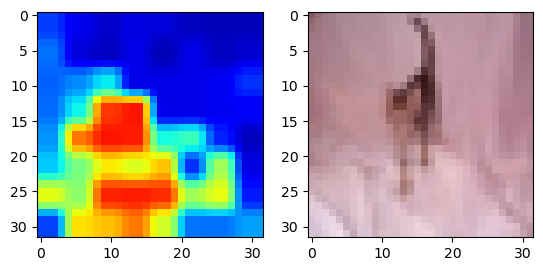

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 3 | True: 6 | Prob: 0.68172
(1, 32, 32, 4)


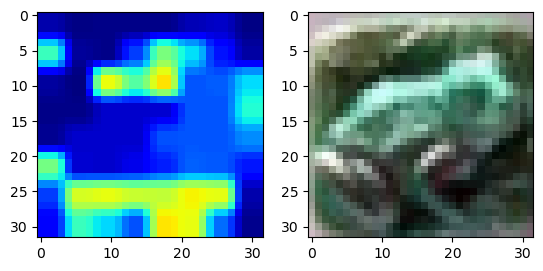

Predicted: 5 | True: 9 | Prob: 0.66312
(1, 32, 32, 4)


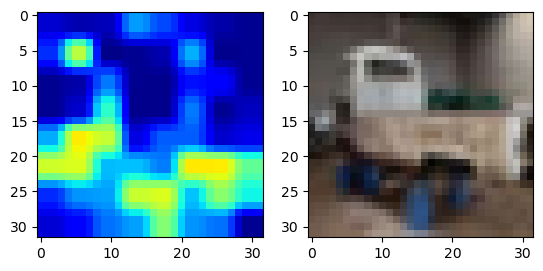

Predicted: 6 | True: 6 | Prob: 0.78958
(1, 32, 32, 4)


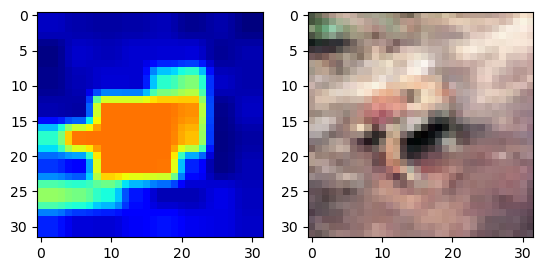

Predicted: 3 | True: 6 | Prob: 0.79808
(1, 32, 32, 4)


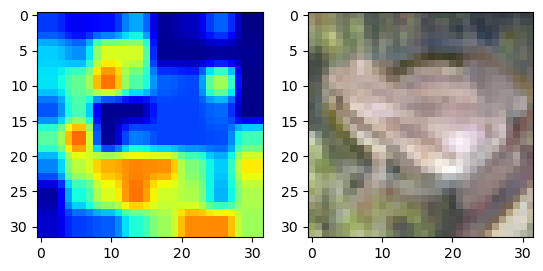

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 2 | True: 2 | Prob: 0.60907
(1, 32, 32, 4)


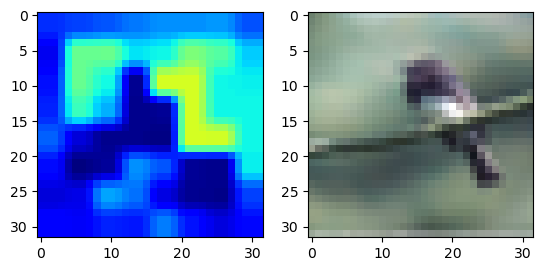

Predicted: 3 | True: 6 | Prob: 0.50442
(1, 32, 32, 4)


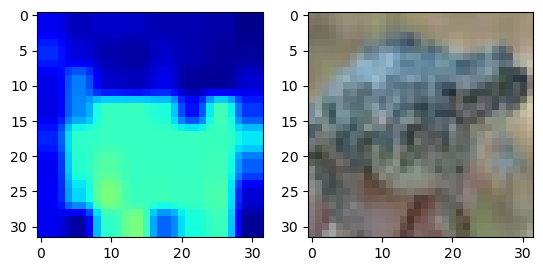

Predicted: 8 | True: 8 | Prob: 0.47397
(1, 32, 32, 4)


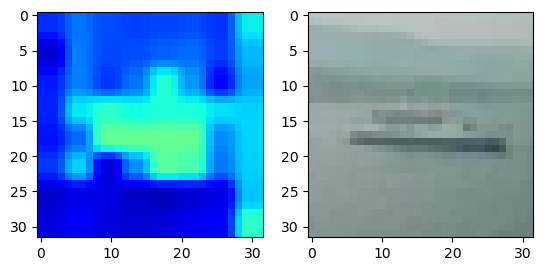

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 5 | True: 5 | Prob: 0.95765
(1, 32, 32, 4)


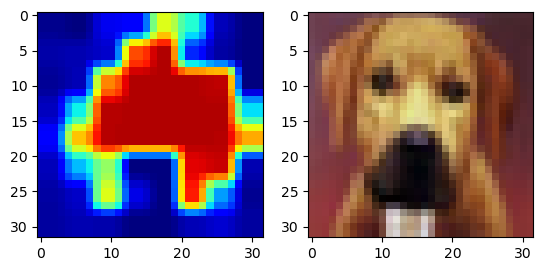

Predicted: 0 | True: 0 | Prob: 0.99318
(1, 32, 32, 4)


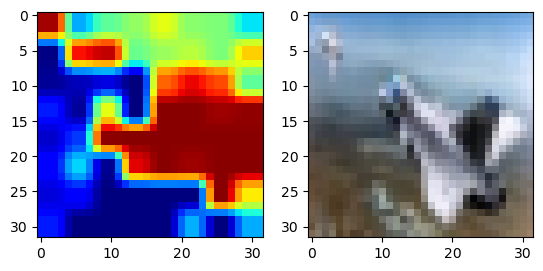

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 2 | True: 2 | Prob: 0.98864
(1, 32, 32, 4)


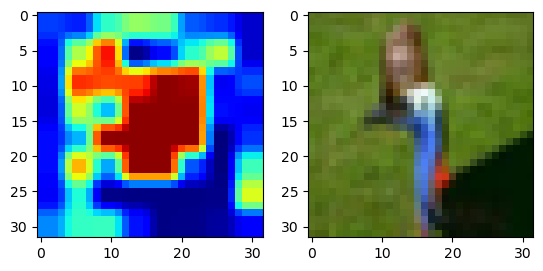

Predicted: 3 | True: 5 | Prob: 0.54005
(1, 32, 32, 4)


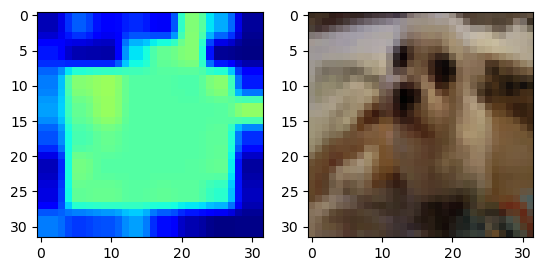

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 3 | True: 3 | Prob: 0.92090
(1, 32, 32, 4)


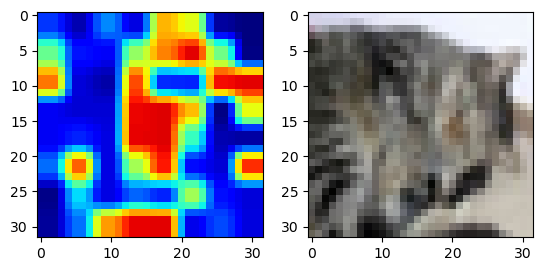

In [50]:
import matplotlib
import cv2
import torchvision.transforms
import torchvision.transforms.functional as TF
import PIL.Image as Image
SIZE_UPSAMPLE = (32,32)
# Calculate CAM

logits, feature_maps = model.localize(images.to(DEVICE).type(torch.float)) # get the feature maps of the last convolutional layer
feature_maps = feature_maps.detach().cpu()

probs = F.softmax(logits, dim=1).detach().cpu() # get the probabilities of the classes
cam, cam_img = get_cam(probs, feature_maps) # generate the CAM for the input image
# one-hot the highest probability class
classes = torch.argmax(probs,dim=1)
from matplotlib import cm

jet = matplotlib.colormaps['jet']
heatmap = jet(cam_img)
print(heatmap.shape)
heatmap = heatmap[:N_IMGS]
for i,h in enumerate(heatmap):
    plt.subplot(1,2,1)
    print(f'Predicted: {classes[i]} | True: {labels[i]} | Prob: {probs[i,classes[i]]:.5f}')
    print(h.shape)
    plt.imshow(h.squeeze(), cmap='jet')
    plt.subplot(1,2,2)
    plt.imshow(images[i].transpose(0,2).transpose(0,1))
    plt.show()

## References
- [1] Ashia C. Wilson, Rebecca Roelofs, Mitchell Stern, Nathan Srebro, and Benjamin Recht. The Marginal Value of Adaptive Gradient Methods in Machine Learning, 2018.
- [2] Lin, Min, Qiang Chen, and Shuicheng Yan. "Network in network." arXiv preprint arXiv:1312.4400 (2013).